In [90]:
import random
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse import csr_matrix
from sklearn import metrics
import implicit
import matplotlib.pylab as plt
import seaborn as sns
from numpy.linalg import solve

In [2]:
col=['UserID','MovieID','Rating','Timestamp']
data=pd.read_csv('../Datasets/ml-100k/u.data',sep='\t',names=col)
data.head()

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
col=['MovieID','movie title', 'release date','video release date ',
              'IMDb URL','unknown', 'Action', 'Adventure','Animation',
              'Children', 'Comedy','Crime ','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical', 'Mystery', 'Romance','Sci-Fi', 
              'Thriller', 'War','Western']
movieInfo=pd.read_csv('../Datasets/ml-100k/u.item',sep='|',names=col,encoding='latin-1')

In [3]:
data['UserID'] = data['UserID'].astype('str')
data['MovieID'] = data['MovieID'].astype('str')
users = data['UserID'].unique() #list of all users
movies = data['MovieID'].unique() #list of all moviesprint("Number of users", len(users))
print("Number of movies", len(movies))
print(data.head())

Number of movies 1682
  UserID MovieID  Rating  Timestamp
0    196     242       3  881250949
1    186     302       3  891717742
2     22     377       1  878887116
3    244      51       2  880606923
4    166     346       1  886397596


In [5]:
#Explatory Data Analysis
print(f"No of users:{len(users)}")
print(f"No of movies:{len(movies)}")


No of users:943
No of movies:1682


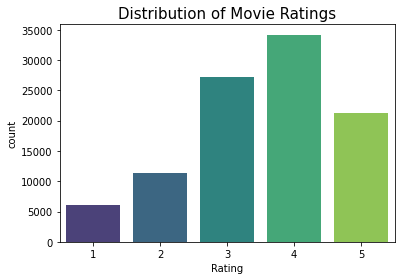

In [8]:
sns.countplot(x="Rating",data=data,palette="viridis")
plt.title("Distribution of Movie Ratings",fontsize=15)
plt.show()

In [9]:
#Calculating Average Rating of every film
avg_rating=data.groupby('MovieID')[['Rating']].mean()

In [19]:
lowest_rated=avg_rating['Rating'].idxmin()

movieInfo[movieInfo['MovieID']==int(lowest_rated)]


,MovieID,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1307,1308,Babyfever (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Babyfever%20(...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
high_rated=avg_rating['Rating'].idxmax()

movieInfo[movieInfo['MovieID']==int(high_rated)]

,MovieID,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1121,1122,They Made Me a Criminal (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?They%20Made%2...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
movie_stats = data.groupby('MovieID')[['Rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [25]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = data.groupby('MovieID')['Rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['MovieID', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='MovieID')

In [34]:
# dataset = data.merge(movieInfo,on='MovieID', how='left')
movie_stats['MovieID']=movie_stats['MovieID'].astype(int)

In [36]:
movie_stats = movie_stats.merge(movieInfo[['MovieID', 'movie title']])

In [38]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,MovieID,count,mean,bayesian_avg,movie title
1336,688,44,1.840909,2.550724,Leave It to Beaver (1997)
1335,687,69,2.188406,2.599239,McHale's Navy (1997)
246,122,106,2.339623,2.604245,"Cable Guy, The (1996)"
1561,890,43,1.953488,2.604903,Mortal Kombat: Annihilation (1997)
1669,988,86,2.313953,2.625454,"Beautician and the Beast, The (1997)"


In [37]:
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,MovieID,count,mean,bayesian_avg,movie title
1128,50,583,4.358491,4.239812,Star Wars (1977)
926,318,298,4.466443,4.235186,Schindler's List (1993)
1283,64,283,4.445230,4.207526,"Shawshank Redemption, The (1994)"
1109,483,243,4.456790,4.185378,Casablanca (1942)
223,12,267,4.385768,4.147243,"Usual Suspects, The (1995)"


In [40]:
def createUtilityMatrix(X,userAll,moviesAll):
    M=len(userAll)
    N=len(moviesAll)
    user_dict=dict(zip(userAll,list(range(M))))
    movie_dict=dict(zip(moviesAll,list(range(N))))
    user_index = [user_dict[i] for i in X['UserID']]
    item_index = [movie_dict[i] for i in X['MovieID']]
    mat = csr_matrix((X["Rating"], (user_index,item_index)), shape=(M,N))
    return mat, user_dict,movie_dict


data_matrix,u_dict,movie_dict=createUtilityMatrix(data,users,movies)



    
    

In [41]:
data_matrix

<943x1682 sparse matrix of type '<class 'numpy.int64'>'
	with 100000 stored elements in Compressed Sparse Row format>

In [43]:
n_total = data_matrix.shape[0]*data_matrix.shape[1]
n_ratings = data_matrix.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 6.3%


In [47]:
n_ratings_per_user = data_matrix.getnnz(axis=1)

print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

n_ratings_per_movie = data_matrix.getnnz(axis=0)

print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most active user rated 737 movies.
Least active user rated 20 movies.
Most rated movie has 583 ratings.
Least rated movie has 1 ratings.


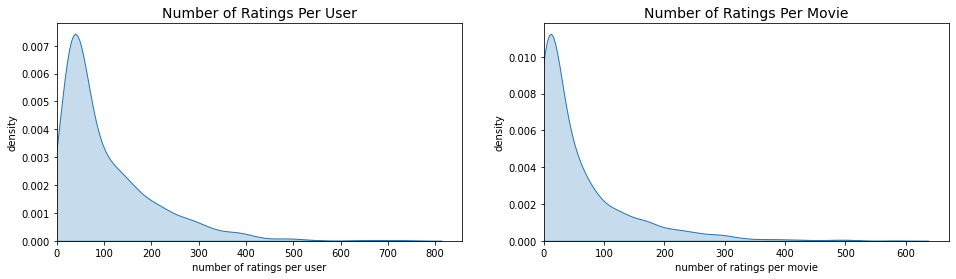

In [48]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()


In [70]:
dp_matrix=data_matrix.toarray()

In [71]:
dp_matrix

array([[3, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [72]:
def train_test_split(ratings):
    print(ratings)
    test = np.zeros(shape=ratings.shape)
    # test=csr_matrix(ratings.shape,dtype=float)
    # print(type(test))
    # print(test.shap)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test
train,test=train_test_split(dp_matrix)

[[3 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [106]:
x=train[0]
max(x)

5

In [98]:
print(test.shape)

(943, 1682)


In [91]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=True):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print ('Train mse: ' + str(self.train_mse[-1]))
                print ('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [76]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [96]:
MF_SGD = ExplicitMF(train, 40, learning='ALS', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('iterations', fontsize=30)
    plt.ylabel('MSE', fontsize=30)
    plt.legend(loc='best', fontsize=20)

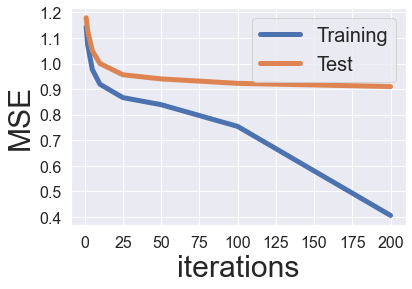

In [95]:
plot_learning_curve(iter_array, MF_SGD)

In [107]:
#Item Based